<a href="https://colab.research.google.com/github/ontenkutsenko/DL_Skin_Disease_Classification/blob/main/4.%20Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [45]:
# !pip install tensorflow_addons
# !pip install opencv-contrib-python

import tensorflow_addons as tfa

import pickle

import pandas as pd
import numpy as np
import os
import requests
from tqdm import tqdm
import shutil
import random

from tensorflow.keras.applications import ResNet50, VGG16, VGG19, imagenet_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras import layers, models
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import Callback

from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.regularizers import l2

import cv2
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
import matplotlib.pyplot as plt
import IPython
import time

from sklearn.metrics import f1_score
import seaborn as sns
from PIL import Image

#### Importing the data

In [2]:
#download weights of the best model
!gdown 1V2FLOfDd-X6-iuFxqsj7wTe6V0MOSsmS

#download images
!gdown 1C8m64W-Tv5R0VJHUtkUXOVt8wZi1coXc

time.sleep(2)

!unzip -q "/content/Images for project.zip" -d /content/
!rm '/content/Images for project.zip'

Downloading...
From: https://drive.google.com/uc?id=1V2FLOfDd-X6-iuFxqsj7wTe6V0MOSsmS
To: /content/model_best_weights1.h5
100% 61.5M/61.5M [00:00<00:00, 76.7MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1C8m64W-Tv5R0VJHUtkUXOVt8wZi1coXc
From (redirected): https://drive.google.com/uc?id=1C8m64W-Tv5R0VJHUtkUXOVt8wZi1coXc&confirm=t&uuid=0c19321d-d210-42cb-be40-a2227ff180a8
To: /content/Images for project.zip
100% 1.42G/1.42G [00:29<00:00, 48.4MB/s]


#### Sorting the images into separate train-val-test folders

In [3]:
url = 'https://raw.githubusercontent.com/ontenkutsenko/DL_Skin_Desease_Classification/main/Data/fitzpatrick17k.csv'
df = pd.read_csv(url).dropna(subset = ['url'])
df = df.sample(frac=1, random_state=10).reset_index(drop=True)

Our dataset contains information of skin color, which may be really important in case of Computer Vision task. We don't want our model to be biased, so we will stratify data in train, validation and test not only by label, but by every skin color, using fitzpatrick_scale. It will help to achieve better generalization and make validation stage more reliable

In [4]:
df['rank'] = df.groupby(['label', 'fitzpatrick_scale']).cumcount()/(df.groupby(['label', 'fitzpatrick_scale']).transform('count')['url'] - 1)

In [5]:
def assign_split(row, proportion):
    if row['rank'] < proportion['train']:
        return 'train'
    elif row['rank'] < proportion['train']+proportion['test']:
        return 'test'
    else:
        return 'val'

In [6]:
# Proportions do not exactly match what we defined because of rare skin color and class combinations that

proportion = {
    'train': 0.70,
    'val': 0.10,
    'test': 0.20
}

df['split'] = df.apply(lambda row: assign_split(row, proportion), axis=1)
df.split.value_counts()/len(df)

split
train    0.687712
test     0.188800
val      0.123488
Name: count, dtype: float64

In [7]:
shutil.rmtree('/content/dataset', ignore_errors=True)

source_folder = '/content/Images for project'
destination_folder = '/content/dataset'


for i in range(len(df)):
  try:
    source_file = os.path.join(source_folder, df['url'][i].split('/')[-1])
    destination_file = os.path.join(destination_folder, df['split'][i], df['label'][i], f"{df['url'][i].split('/')[-1]}.jpg")
    os.makedirs(os.path.dirname(destination_file), exist_ok=True)

    shutil.move(source_file, destination_file)
  except:
    print(source_file, ' doesn\'t exist')

/content/Images for project/img?imageId=4030  doesn't exist
/content/Images for project/img?imageId=8364  doesn't exist
/content/Images for project/img?imageId=2767  doesn't exist
/content/Images for project/img?imageId=4031  doesn't exist
/content/Images for project/img?imageId=5399  doesn't exist
/content/Images for project/img?imageId=2766  doesn't exist
/content/Images for project/img?imageId=6724  doesn't exist
/content/Images for project/img?imageId=4505  doesn't exist
/content/Images for project/img?imageId=8362  doesn't exist
/content/Images for project/img?imageId=8363  doesn't exist


#### Define model and test data generator

In [8]:
# Data generator
test_datagen = ImageDataGenerator(rescale=1./255)

# Model
batch_size = 64

input_size = (128,128)

test_generator = test_datagen.flow_from_directory(
        'dataset/test',
        batch_size=batch_size,
        shuffle = False,
        class_mode='categorical',
        target_size=input_size)

tf.compat.v1.reset_default_graph()


# Our model
base_model = VGG16(include_top=False, weights='imagenet', input_shape=input_size + (3,))
for layer in base_model.layers[:-8]:
    layer.trainable = False

model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(1024, activation='relu',
                     kernel_regularizer=l2(0.001)),
        layers.Dropout(0.3),
        layers.Dense(114, activation='softmax')
    ])


sgd_optimizer = SGD(lr=0.001, momentum=0.9)

weighted_f1_score = tfa.metrics.F1Score(num_classes=114, average = 'weighted', name = 'weighted_f1')
macro_f1_score = tfa.metrics.F1Score(num_classes=114, average = 'macro', name = 'macro_f1')

model.compile(optimizer=sgd_optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', weighted_f1_score, macro_f1_score])

model.load_weights('/content/model_best_weights1.h5')

print(model.layers[-1].weights[0])

# for layer in model.layers[:]:
#     layer.trainable = False

# Flattening VGG16 functional layer
Layers = model.layers[0].layers
Layers.extend(model.layers[1:])
Layers

model_1 = Sequential(Layers)

Found 3118 images belonging to 114 classes.
58889256/58889256 [==============================] - 3s 0us/step


<tf.Variable 'dense_1/kernel:0' shape=(1024, 114) dtype=float32, numpy=
array([[-0.03253018, -0.05704322, -0.00793991, ..., -0.03282168,
         0.05668855,  0.05340216],
       [-0.03435608,  0.06223971,  0.05420537, ..., -0.0850201 ,
         0.02538965, -0.08534566],
       [ 0.0329469 , -0.05470935, -0.08793449, ..., -0.00964136,
        -0.07963009,  0.05680752],
       ...,
       [-0.00922461, -0.00840289, -0.05118082, ..., -0.06416316,
        -0.05640882, -0.06222881],
       [ 0.01250855, -0.07379591,  0.01764126, ..., -0.04263733,
         0.03961803,  0.03128516],
       [-0.08074917, -0.01514399, -0.0786344 , ...,  0.00942303,
         0.1044959 ,  0.03466671]], dtype=float32)>


#### Save predictions and true values

In [9]:
predictions = model_1.predict(test_generator, verbose = 'auto')

predicted_classes = predictions.argmax(axis=1)

len(predicted_classes)

49/49 [==============================] - 639s 13s/step


3118

In [10]:
#create dataframe for analysis

url = 'https://raw.githubusercontent.com/ontenkutsenko/DL_Skin_Desease_Classification/main/Data/fitzpatrick17k.csv'
df1 = pd.read_csv(url).dropna(subset = ['url'])
df1['key'] = df1['label'] + '/' + df1['url'].apply(lambda x: x.split('/')[-1] + '.jpg')
df2 = pd.DataFrame({
    'key': test_generator.filenames,
    'true_class': test_generator.classes,
    'pred_class': predictions.argmax(axis=1),
    'pred_prob' : predictions.tolist()
})
reverse_dict = {value: key for key, value in test_generator.class_indices.items()}
df2['pred_label'] = df2['pred_class'].apply(lambda x: reverse_dict[x])

test_info = pd.merge(df1, df2, left_on='key', right_on='key')
test_info.head()

md5hash  fitzpatrick_scale  fitzpatrick_centaur  \
0  fa2911a9b13b6f8af79cb700937cc14f                  1                    1   
1  e702b1a7dc40aa1d8e85ccdb019c4ab2                  1                    1   
2  8438db40abd1eccfbc7ee4b469f1b6f1                  4                    3   
3  b09233673fc585369e723ec841ed0acb                  5                    3   
4  fb9640a13e0c11610684fe8c0f473cf2                  2                    2   

                     label nine_partition_label three_partition_label   qc  \
0          photodermatoses         inflammatory        non-neoplastic  NaN   
1  neutrophilic dermatoses         inflammatory        non-neoplastic  NaN   
2    necrobiosis lipoidica         inflammatory        non-neoplastic  NaN   
3        actinic keratosis  malignant epidermal             malignant  NaN   
4                syringoma        benign dermal                benign  NaN   

                                                 url  \
0  https://www.dermaamin.com/site/images/clinical...   
1  https://www.dermaamin.com/site/images/clinical...   
2  https://www.dermaamin.com/site/images/clinical...   
3  https://www.dermaamin.com/site/images/clinical...   
4  https://www.dermaamin.com/site/images/clinical...   

                                        url_alphanum  \
0  httpwwwdermaamincomsiteimagesclinicalpicpphoto...   
1  httpwwwdermaamincomsiteimagesclinicalpicssweet...   
2  httpwwwdermaamincomsiteimagesclinicalpicnnecro...   
3  httpwwwdermaamincomsiteimagesclinicalpicaactin...   
4  httpwwwdermaamincomsiteimagesclinicalpicssyrin...   

                                                 key  true_class  pred_class  \
0         photodermatoses/photosensitivity18.jpg.jpg          75         109   
1   neutrophilic dermatoses/sweet-syndrome50.jpg.jpg          68          91   
2  necrobiosis lipoidica/necrobiois-lipoidica-dia...          63          75   
3      actinic keratosis/actinic_keratoses83.jpg.jpg           5           5   
4                      syringoma/syringoma33.jpg.jpg         104         109   

                                           pred_prob         pred_label  
0  [0.0013518667547032237, 0.0005221636965870857,...          urticaria  
1  [9.992952527682064e-07, 0.008935791440308094, ...        sarcoidosis  
2  [1.971695019165054e-05, 1.241669542650925e-05,...    photodermatoses  
3  [1.182959385914728e-05, 0.0013660775730386376,...  actinic keratosis  
4  [0.0007367891375906765, 0.001531527261249721, ...          urticaria

#### Define metrics and calculate overall performance

In [12]:
def top_n_accuracy(y_val, val_predictions, n):
  diff = np.min(np.abs(y_val.reshape(-1, 1) - np.argsort(val_predictions, axis=1)[:,-n:]), axis = 1)
  return np.count_nonzero(diff == 0)/len(diff)

In [15]:
print(f"Test accuracy: {np.round(top_n_accuracy(test_info['true_class'].to_numpy(), np.array(test_info['pred_prob'].to_list()), 1), 3)}")
print(f"Test top-3 accuracy: {np.round(top_n_accuracy(test_info['true_class'].to_numpy(), np.array(test_info['pred_prob'].to_list()), 3), 3)}")
print(f"Test top-5 accuracy: {np.round(top_n_accuracy(test_info['true_class'].to_numpy(), np.array(test_info['pred_prob'].to_list()), 5), 3)}")
print(f"Test weighted F1: {np.round(f1_score(test_info['true_class'].to_numpy(), test_info['pred_class'].to_numpy(), average='weighted'), 3)}")
print(f"Test macro F1: {np.round(f1_score(test_info['true_class'].to_numpy(), test_info['pred_class'].to_numpy(), average='macro'), 3)}")

Test accuracy: 0.386
Test top-3 accuracy: 0.553
Test top-5 accuracy: 0.633
Test weighted F1: 0.383
Test macro F1: 0.355


#### Diseases perspective

100%|██████████| 114/114 [00:00<00:00, 209.14it/s]


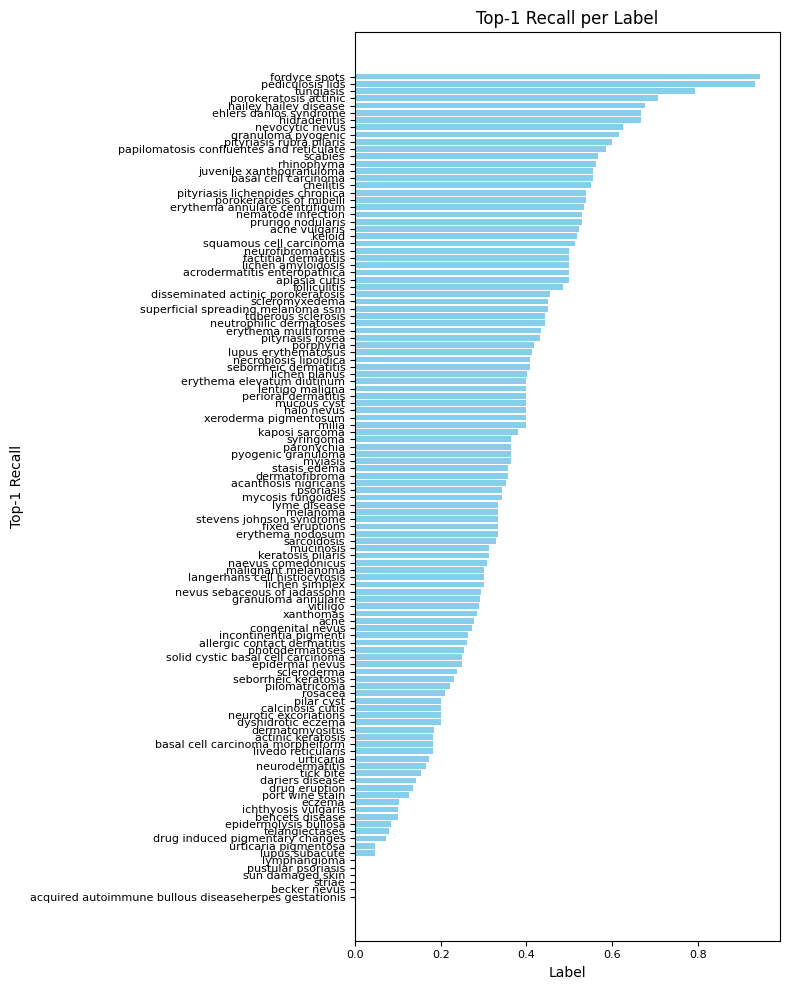

100%|██████████| 114/114 [00:00<00:00, 415.61it/s]


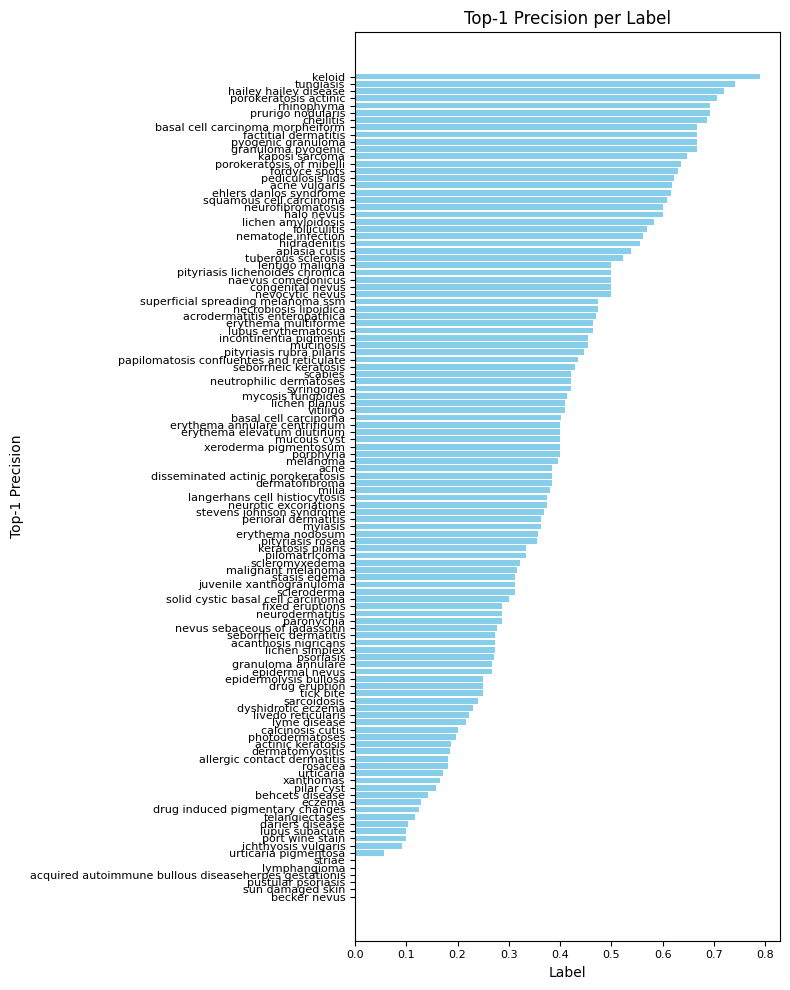

In [16]:
# It's not accuracy, but recall


category = 'label'

cat_calc = []
for i in tqdm(list(set(test_info[category]))):
  cat_slice_df = test_info[test_info[category] == i]
  top_1 = top_n_accuracy(cat_slice_df['true_class'].to_numpy(), np.array(cat_slice_df['pred_prob'].to_list()), 1)
  top_3 = top_n_accuracy(cat_slice_df['true_class'].to_numpy(), np.array(cat_slice_df['pred_prob'].to_list()), 3)
  top_5 = top_n_accuracy(cat_slice_df['true_class'].to_numpy(), np.array(cat_slice_df['pred_prob'].to_list()), 5)

  cat_calc.append([i, len(cat_slice_df), top_1, top_3, top_5])
cat_performance_df = pd.DataFrame(cat_calc, columns= ['label', 'count', 'top_1_recall', 'top_3_recall', 'top_5_recall'])

sorted_df = cat_performance_df.sort_values(by='top_1_recall', ascending=True)


plt.figure(figsize=(8, 10))
plt.barh(sorted_df['label'], sorted_df['top_1_recall'], color='skyblue')
plt.title('Top-1 Recall per Label')
plt.xlabel('Label')
plt.ylabel('Top-1 Recall')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()


# Its not accuracy, but precision

cat_calc = []
category = 'pred_label'
for i in tqdm(list(set(test_info[category]))):
  cat_slice_df = test_info[test_info[category] == i]
  top_1 = top_n_accuracy(cat_slice_df['true_class'].to_numpy(), np.array(cat_slice_df['pred_prob'].to_list()), 1)
  top_3 = top_n_accuracy(cat_slice_df['true_class'].to_numpy(), np.array(cat_slice_df['pred_prob'].to_list()), 3)
  top_5 = top_n_accuracy(cat_slice_df['true_class'].to_numpy(), np.array(cat_slice_df['pred_prob'].to_list()), 5)

  cat_calc.append([i, len(cat_slice_df), top_1, top_3, top_5])
cat_performance_df_1 = pd.DataFrame(cat_calc, columns= ['label', 'count', 'top_1_precision', 'top_3_precision', 'top_5_precision'])

sorted_df = cat_performance_df_1.sort_values(by='top_1_precision', ascending=True)


plt.figure(figsize=(8, 10))
plt.barh(sorted_df['label'], sorted_df['top_1_precision'], color='skyblue')
# plt.plot(sorted_df['count'], sorted_df['label'], color='skyblue')
plt.title('Top-1 Precision per Label')
plt.xlabel('Label')
plt.ylabel('Top-1 Precision')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

In [17]:
# Recall on 30 biggest true classes

cat_performance_df.sort_values(by='count', ascending=False).head(30).drop('label', axis = 1).mean()

count           57.366667
top_1_recall     0.420839
top_3_recall     0.575795
top_5_recall     0.652144
dtype: float64

In [18]:
# Precision on 30 biggest predicted classes

cat_performance_df_1.sort_values(by='count', ascending=False).head(30).drop('label', axis = 1).mean()

count              62.466667
top_1_precision     0.401775
top_3_precision     0.568738
top_5_precision     0.640383
dtype: float64

In [19]:
# Recall on 30 smallest classes

cat_performance_df.sort_values(by='count', ascending=False).tail(30).drop('label', axis = 1).mean()

count           10.966667
top_1_recall     0.247858
top_3_recall     0.414636
top_5_recall     0.493994
dtype: float64

In [20]:
# Precision on 30 smallest predicted classes

cat_performance_df_1.sort_values(by='count', ascending=False).tail(30).drop('label', axis = 1).mean()

count              7.900000
top_1_precision    0.287368
top_3_precision    0.427908
top_5_precision    0.506562
dtype: float64

If we look on count number - average count of top predicted classes is way bigger than average count of top true classes. And the opposite for smallest. It means that distribution of predicted classes is way more extreme - model likes to predict some classes that it have seen more or know batter. Let's compare what are the most/least popular true classes and most/least popular predicted classes (!! might change when we put different model)

In [21]:
pop_pred = set(cat_performance_df_1.sort_values(by='count', ascending=False).head(30)['label'])
pop_true = set(cat_performance_df.sort_values(by='count', ascending=False).head(30)['label'])

len(pop_pred.intersection(pop_true))

24

In [22]:
unpop_pred = set(cat_performance_df_1.sort_values(by='count', ascending=False).tail(30)['label'])
unpop_true = set(cat_performance_df.sort_values(by='count', ascending=False).tail(30)['label'])

len(unpop_pred.intersection(unpop_true))

23

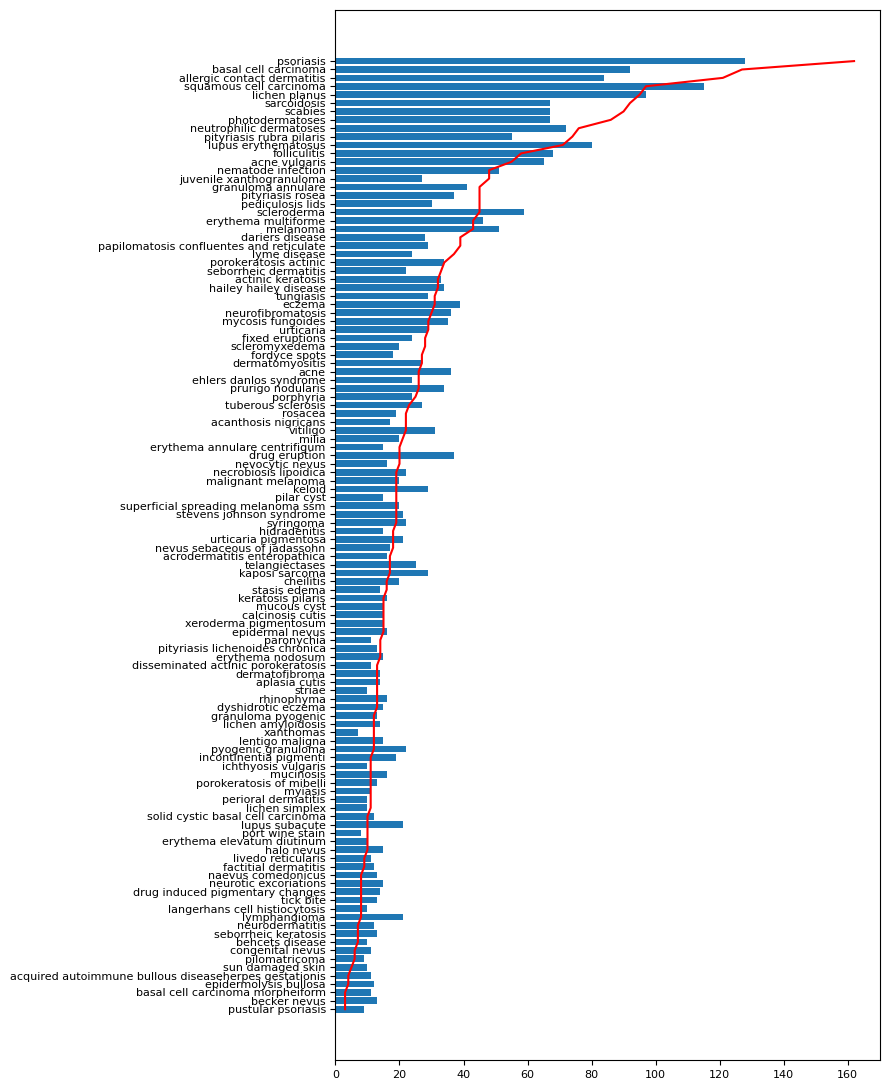

In [23]:
plt.figure(figsize=(9, 11))

plt.plot(cat_performance_df_1.sort_values(by = 'count')['count'],
         cat_performance_df_1.sort_values(by = 'count')['label'],
         color = 'red')
plt.barh(cat_performance_df['label'], cat_performance_df['count'])

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

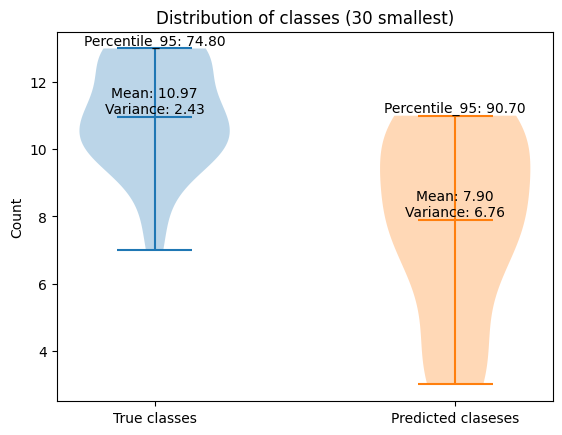

In [37]:
mean_1 = np.mean(cat_performance_df.sort_values(by='count', ascending=False).tail(30)['count'])
mean_2 = np.mean(cat_performance_df_1.sort_values(by='count', ascending=False).tail(30)['count'])
variance_1 = np.var(cat_performance_df.sort_values(by='count', ascending=False).tail(30)['count'])
variance_2 = np.var(cat_performance_df_1.sort_values(by='count', ascending=False).tail(30)['count'])
percentile_95_1 = np.percentile(cat_performance_df.sort_values(by='count', ascending=False).tail(30)['count'], 95)
percentile_95_2 = np.percentile(cat_performance_df_1.sort_values(by='count', ascending=False).tail(30)['count'], 95)


plt.violinplot(cat_performance_df.sort_values(by='count', ascending=False).tail(30)['count'], positions=[1], widths=0.5, showmeans=True)
plt.violinplot(cat_performance_df_1.sort_values(by='count', ascending=False).tail(30)['count'], positions=[2], widths=0.5, showmeans=True)

plt.text(1, mean_1, f'Mean: {mean_1:.2f}\nVariance: {variance_1:.2f}', horizontalalignment='center', verticalalignment='bottom')
plt.text(2, mean_2, f'Mean: {mean_2:.2f}\nVariance: {variance_2:.2f}', horizontalalignment='center', verticalalignment='bottom')

plt.text(1, percentile_95_1, f'Percentile_95: {percentile_90_1:.2f}', horizontalalignment='center', verticalalignment='bottom')
plt.text(2, percentile_95_2, f'Percentile_95: {percentile_90_2:.2f}', horizontalalignment='center', verticalalignment='bottom')

plt.xticks([1,2], ['True classes', 'Predicted claseses'])
plt.ylabel('Count')
plt.title('Distribution of classes (30 smallest)')

plt.show()


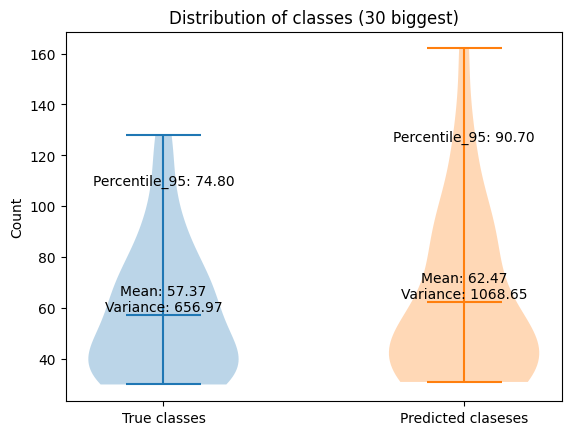

In [38]:
mean_1 = np.mean(cat_performance_df.sort_values(by='count', ascending=False).head(30)['count'])
mean_2 = np.mean(cat_performance_df_1.sort_values(by='count', ascending=False).head(30)['count'])
variance_1 = np.var(cat_performance_df.sort_values(by='count', ascending=False).head(30)['count'])
variance_2 = np.var(cat_performance_df_1.sort_values(by='count', ascending=False).head(30)['count'])
percentile_95_1 = np.percentile(cat_performance_df.sort_values(by='count', ascending=False).head(30)['count'], 95)
percentile_95_2 = np.percentile(cat_performance_df_1.sort_values(by='count', ascending=False).head(30)['count'], 95)


plt.violinplot(cat_performance_df.sort_values(by='count', ascending=False).head(30)['count'], positions=[1], widths=0.5, showmeans=True)
plt.violinplot(cat_performance_df_1.sort_values(by='count', ascending=False).head(30)['count'], positions=[2], widths=0.5, showmeans=True)

plt.text(1, mean_1, f'Mean: {mean_1:.2f}\nVariance: {variance_1:.2f}', horizontalalignment='center', verticalalignment='bottom')
plt.text(2, mean_2, f'Mean: {mean_2:.2f}\nVariance: {variance_2:.2f}', horizontalalignment='center', verticalalignment='bottom')

plt.text(1, percentile_95_1, f'Percentile_95: {percentile_90_1:.2f}', horizontalalignment='center', verticalalignment='bottom')
plt.text(2, percentile_95_2, f'Percentile_95: {percentile_90_2:.2f}', horizontalalignment='center', verticalalignment='bottom')

plt.xticks([1,2], ['True classes', 'Predicted claseses'])
plt.ylabel('Count')
plt.title('Distribution of classes (30 biggest)')

plt.show()

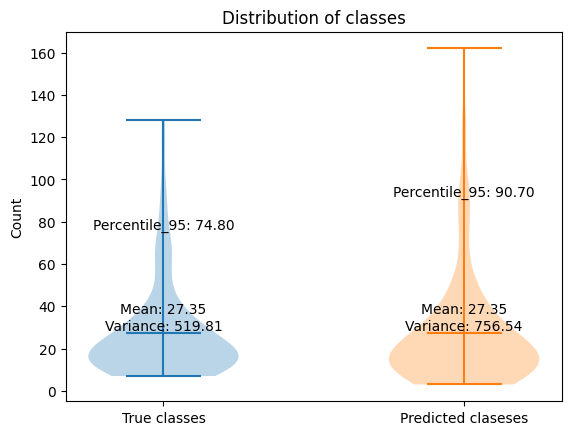

In [39]:
mean_1 = np.mean(cat_performance_df['count'])
mean_2 = np.mean(cat_performance_df_1['count'])
variance_1 = np.var(cat_performance_df['count'])
variance_2 = np.var(cat_performance_df_1['count'])
percentile_95_1 = np.percentile(cat_performance_df['count'], 95)
percentile_95_2 = np.percentile(cat_performance_df_1['count'], 95)


plt.violinplot(cat_performance_df['count'], positions=[1], widths=0.5, showmeans=True)
plt.violinplot(cat_performance_df_1['count'], positions=[2], widths=0.5, showmeans=True)

plt.text(1, mean_1, f'Mean: {mean_1:.2f}\nVariance: {variance_1:.2f}', horizontalalignment='center', verticalalignment='bottom')
plt.text(2, mean_2, f'Mean: {mean_2:.2f}\nVariance: {variance_2:.2f}', horizontalalignment='center', verticalalignment='bottom')

plt.text(1, percentile_95_1, f'Percentile_95: {percentile_90_1:.2f}', horizontalalignment='center', verticalalignment='bottom')
plt.text(2, percentile_95_2, f'Percentile_95: {percentile_90_2:.2f}', horizontalalignment='center', verticalalignment='bottom')

plt.xticks([1,2], ['True classes', 'Predicted claseses'])
plt.ylabel('Count')
plt.title('Distribution of classes')

plt.show()

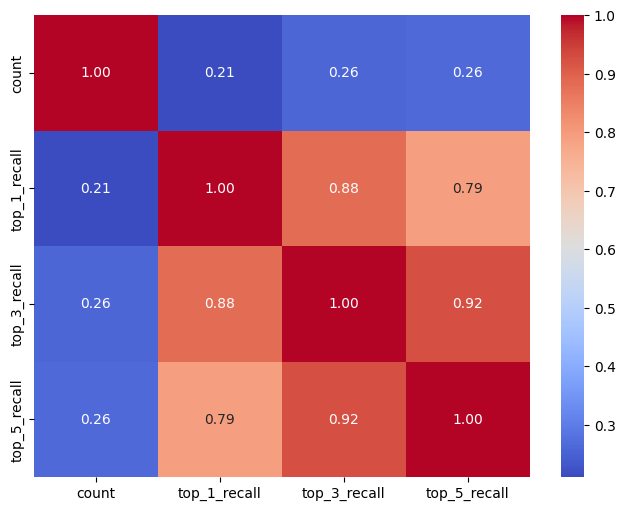

In [40]:
correlation_matrix = cat_performance_df.select_dtypes(include='number').corr()
# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

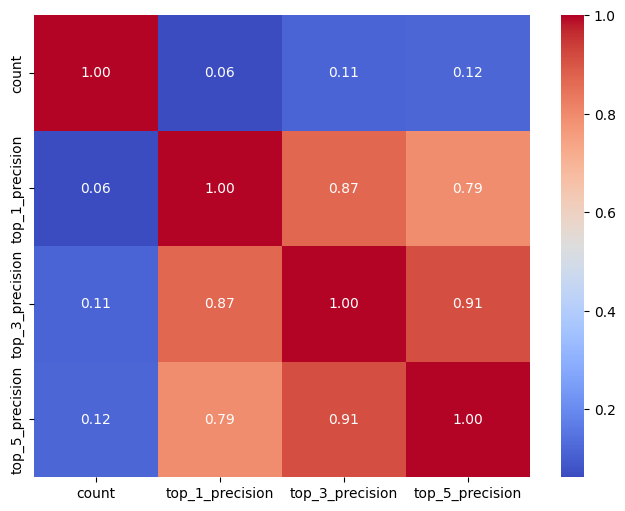

In [41]:
correlation_matrix = cat_performance_df_1.select_dtypes(include='number').corr()
# Create heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

Slightly positive correlation of counts and recall means that the bigger the class we are more likely to correctly identify most of its images

##### skin tone perspective

100%|██████████| 7/7 [00:00<00:00, 29.86it/s]


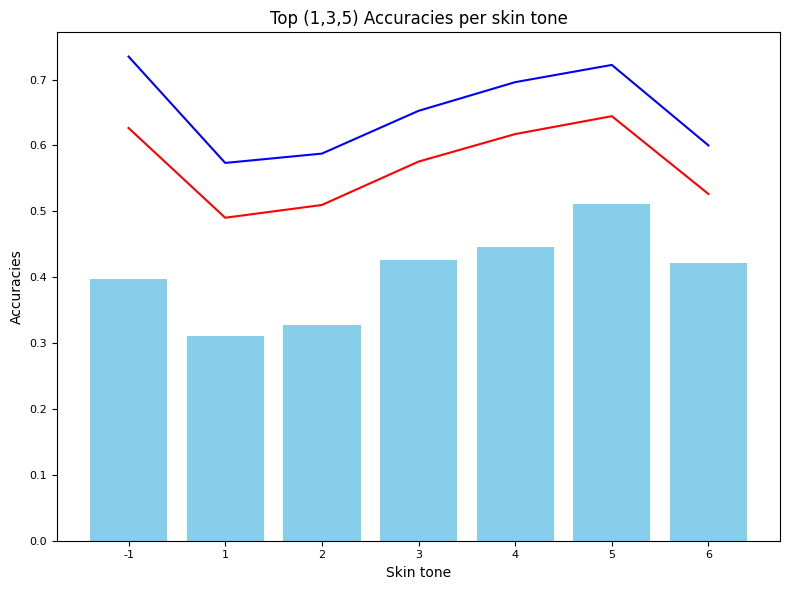

In [137]:
category = 'fitzpatrick_scale'

cat_calc = []
for i in tqdm(list(set(test_info[category]))):
  cat_slice_df = test_info[test_info[category] == i]
  top_1 = top_n_accuracy(cat_slice_df['true_class'].to_numpy(), np.array(cat_slice_df['pred_prob'].to_list()), 1)
  top_3 = top_n_accuracy(cat_slice_df['true_class'].to_numpy(), np.array(cat_slice_df['pred_prob'].to_list()), 3)
  top_5 = top_n_accuracy(cat_slice_df['true_class'].to_numpy(), np.array(cat_slice_df['pred_prob'].to_list()), 5)

  cat_calc.append([i, len(cat_slice_df), top_1, top_3, top_5])
skin_tone_df = pd.DataFrame(cat_calc, columns= ['label', 'count', 'top_1_acc', 'top_3_acc', 'top_5_acc'])

sorted_df = skin_tone_df.sort_values(by='label', ascending=True)


plt.figure(figsize=(8,6))
plt.bar(sorted_df['label'].astype(str), sorted_df['top_1_acc'], color='skyblue')
plt.plot( sorted_df['label'].astype(str), sorted_df['top_3_acc'], color='red')
plt.plot( sorted_df['label'].astype(str), sorted_df['top_5_acc'], color='blue')
plt.title('Top (1,3,5) Accuracies per skin tone')
plt.xlabel('Skin tone')
plt.ylabel('Accuracies')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

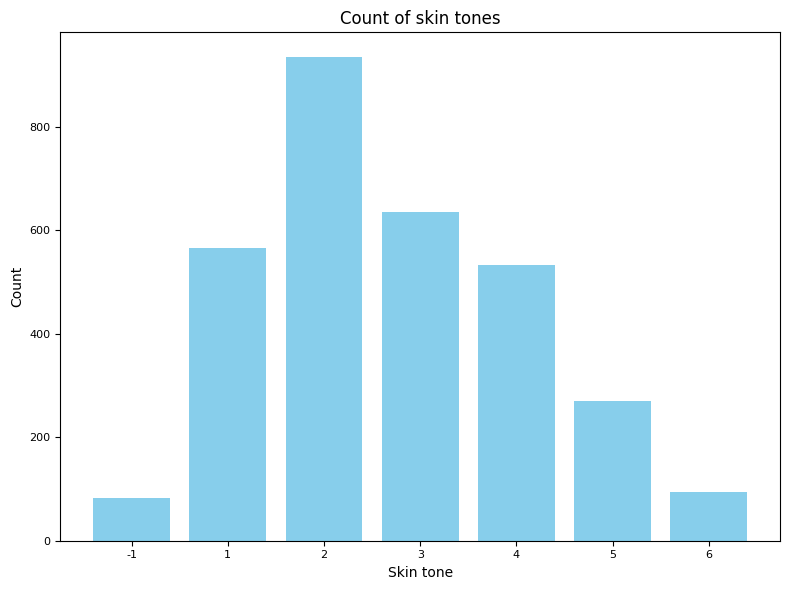

In [138]:
plt.figure(figsize=(8,6))
plt.bar(sorted_df['label'].astype(str), sorted_df['count'], color='skyblue')
plt.title('Count of skin tones')
plt.xlabel('Skin tone')
plt.ylabel('Count')
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

#### nine partition perspective

100%|██████████| 9/9 [00:00<00:00, 40.86it/s]


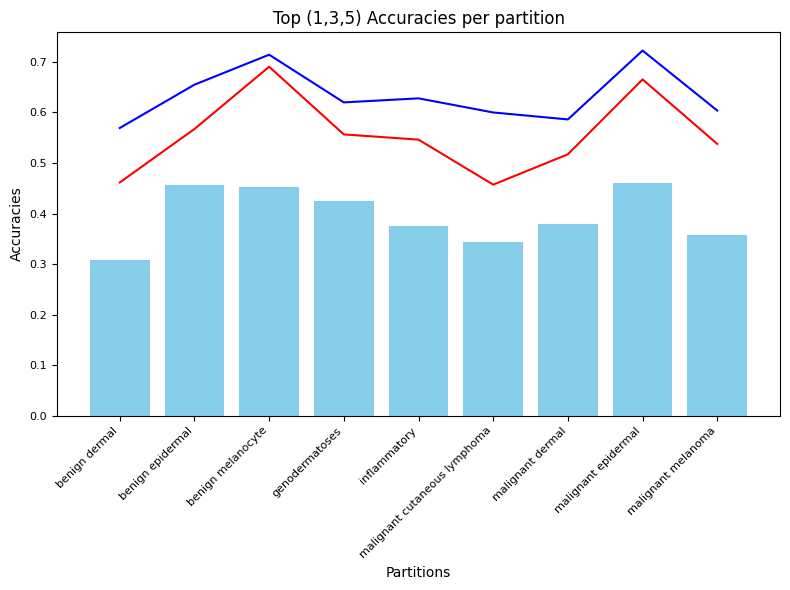

In [147]:
category = 'nine_partition_label'

cat_calc = []
for i in tqdm(list(set(test_info[category]))):
  cat_slice_df = test_info[test_info[category] == i]
  top_1 = top_n_accuracy(cat_slice_df['true_class'].to_numpy(), np.array(cat_slice_df['pred_prob'].to_list()), 1)
  top_3 = top_n_accuracy(cat_slice_df['true_class'].to_numpy(), np.array(cat_slice_df['pred_prob'].to_list()), 3)
  top_5 = top_n_accuracy(cat_slice_df['true_class'].to_numpy(), np.array(cat_slice_df['pred_prob'].to_list()), 5)

  cat_calc.append([i, len(cat_slice_df), top_1, top_3, top_5])
partition_df = pd.DataFrame(cat_calc, columns= ['label', 'count', 'top_1_acc', 'top_3_acc', 'top_5_acc'])

sorted_df = partition_df.sort_values(by='label', ascending=True)


plt.figure(figsize=(8,6))
plt.bar(sorted_df['label'].astype(str), sorted_df['top_1_acc'], color='skyblue')
plt.plot( sorted_df['label'].astype(str), sorted_df['top_3_acc'], color='red')
plt.plot( sorted_df['label'].astype(str), sorted_df['top_5_acc'], color='blue')
plt.title('Top (1,3,5) Accuracies per partition')
plt.xlabel('Partitions')
plt.ylabel('Accuracies')
plt.xticks(fontsize=8, rotation = 45, ha='right')
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()



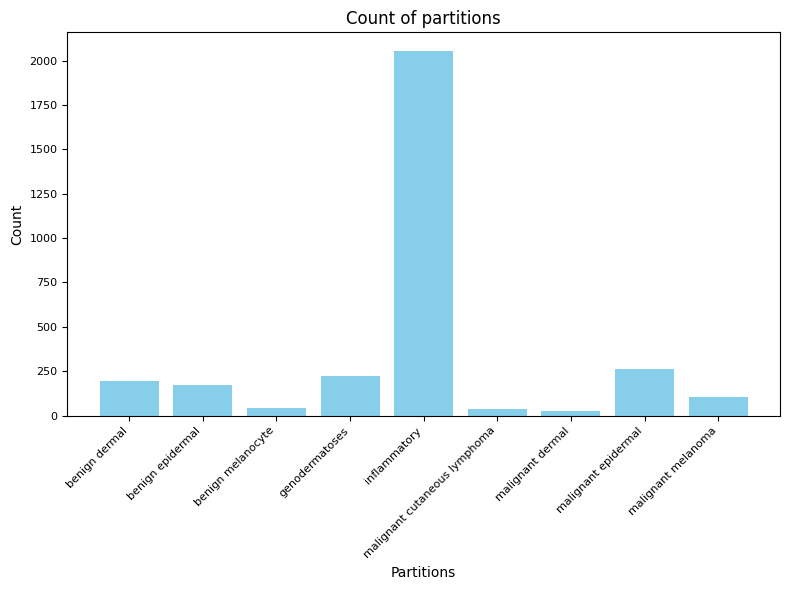

In [149]:
plt.figure(figsize=(8,6))
plt.bar(sorted_df['label'].astype(str), sorted_df['count'], color='skyblue')
plt.title('Count of partitions')
plt.xlabel('Partitions')
plt.ylabel('Count')
plt.xticks(fontsize=8, rotation = 45, ha='right')
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

#### 3 partitions perspective

100%|██████████| 3/3 [00:00<00:00, 13.45it/s]


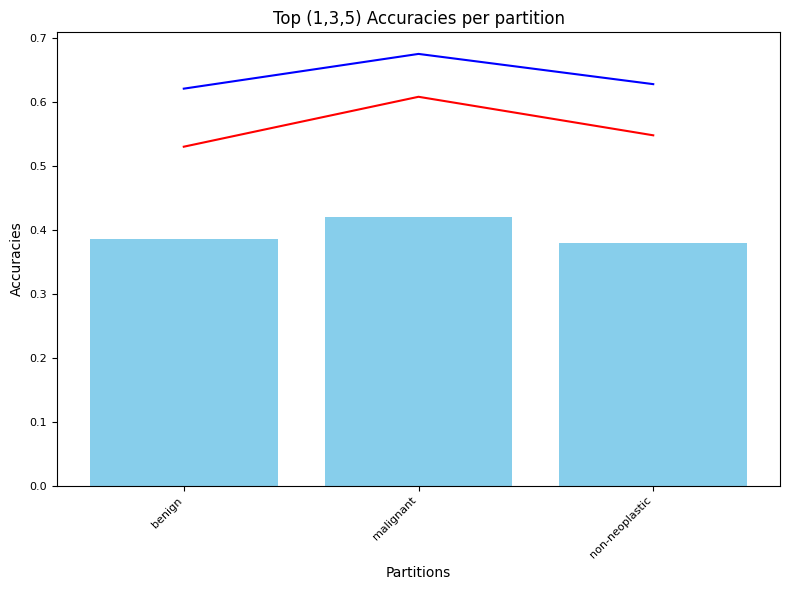

In [150]:
category = 'three_partition_label'

cat_calc = []
for i in tqdm(list(set(test_info[category]))):
  cat_slice_df = test_info[test_info[category] == i]
  top_1 = top_n_accuracy(cat_slice_df['true_class'].to_numpy(), np.array(cat_slice_df['pred_prob'].to_list()), 1)
  top_3 = top_n_accuracy(cat_slice_df['true_class'].to_numpy(), np.array(cat_slice_df['pred_prob'].to_list()), 3)
  top_5 = top_n_accuracy(cat_slice_df['true_class'].to_numpy(), np.array(cat_slice_df['pred_prob'].to_list()), 5)

  cat_calc.append([i, len(cat_slice_df), top_1, top_3, top_5])
partition3_df = pd.DataFrame(cat_calc, columns= ['label', 'count', 'top_1_acc', 'top_3_acc', 'top_5_acc'])

sorted_df = partition3_df.sort_values(by='label', ascending=True)


plt.figure(figsize=(8,6))
plt.bar(sorted_df['label'].astype(str), sorted_df['top_1_acc'], color='skyblue')
plt.plot( sorted_df['label'].astype(str), sorted_df['top_3_acc'], color='red')
plt.plot( sorted_df['label'].astype(str), sorted_df['top_5_acc'], color='blue')
plt.title('Top (1,3,5) Accuracies per partition')
plt.xlabel('Partitions')
plt.ylabel('Accuracies')
plt.xticks(fontsize=8, rotation = 45, ha='right')
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()


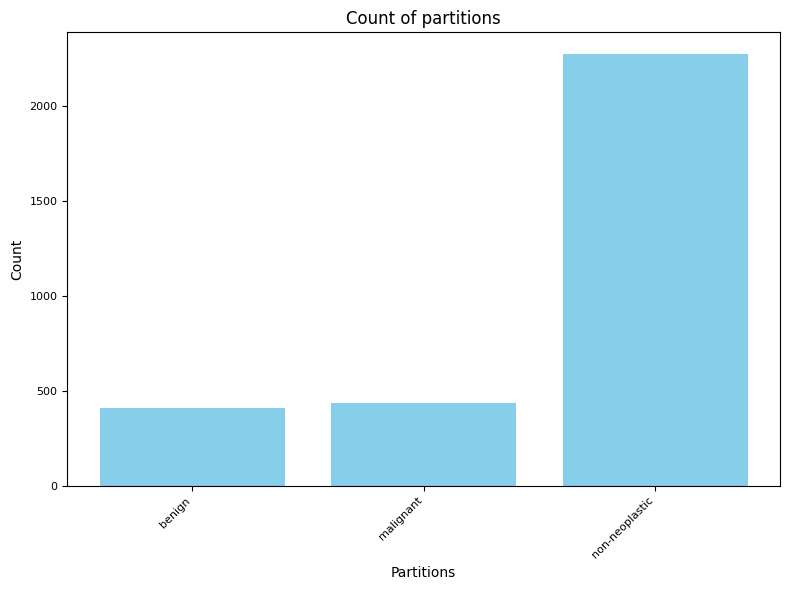

In [151]:
plt.figure(figsize=(8,6))
plt.bar(sorted_df['label'].astype(str), sorted_df['count'], color='skyblue')
plt.title('Count of partitions')
plt.xlabel('Partitions')
plt.ylabel('Count')
plt.xticks(fontsize=8, rotation = 45, ha='right')
plt.yticks(fontsize=8)
plt.tight_layout()
plt.show()

#### Most typical mistakes

In [166]:
data = test_info.groupby(['label', 'pred_label']).size().unstack(fill_value=0)
shares = data/data.sum(axis = 1)
np.fill_diagonal(shares.values, 0)

In [173]:
max_values = shares.idxmax(axis="columns")

max_values_list = []

for i in max_values.index:
  max_values_list.append([i,
                          max_values.loc[i],
                          shares.loc[i][max_values.loc[i]],
                          data.loc[i][max_values.loc[i]],
                          (shares.loc[i] != 0).sum(),
                          (shares.loc[i] != 0).sum()/data.loc[i].sum()
                          ])

errors_df = pd.DataFrame(max_values_list, columns = ['True class',
                                         'Most popular mistake',
                                         'Share of most popular mistake',
                                         'Count of most popular mistake',
                                         'Num unique classes mistake',
                                         'Share unique classes mistake of class size'])

In [126]:
#rosacea and rhinophyma, acne	and acne vulgaris	- good examples of confusion beacuse of similar classes

errors_df.sort_values(by='Count of most popular mistake', ascending=False).head(10)

True class  \
1                                  acne   
97    solid cystic basal cell carcinoma   
67                neurotic excoriations   
0                  acanthosis nigricans   
90                              rosacea   
89                           rhinophyma   
103  superficial spreading melanoma ssm   
10                         becker nevus   
86                            psoriasis   
52                       lupus subacute   

                         Most popular mistake  Share of most popular mistake  \
1                               acne vulgaris                       0.107692   
97                       basal cell carcinoma                       0.054348   
67                                sarcoidosis                       0.074627   
0    papilomatosis confluentes and reticulate                       0.137931   
90                                 rhinophyma                       0.250000   
89                                    rosacea                       0.210526   
103                           nevocytic nevus                       0.250000   
10                   juvenile xanthogranuloma                       0.148148   
86                      seborrheic dermatitis                       0.181818   
52                                    rosacea                       0.157895   

     Count of most popular mistake  Num unique classes mistake  
1                                7                          17  
97                               5                           5  
67                               5                           5  
0                                4                           8  
90                               4                           9  
89                               4                           4  
103                              4                           7  
10                               4                          10  
86                               4                          46  
52                               3                          14

In [127]:
#close to what we had before

errors_df.sort_values(by='Share of most popular mistake', ascending=False).head(10)

True class               Most popular mistake  \
51                  lupus erythematosus                    port wine stain   
90                              rosacea                         rhinophyma   
103  superficial spreading melanoma ssm                    nevocytic nevus   
9      basal cell carcinoma morpheiform  solid cystic basal cell carcinoma   
88                   pyogenic granuloma                 granuloma pyogenic   
48                        lichen planus                 lichen amyloidosis   
89                           rhinophyma                            rosacea   
70         nevus sebaceous of jadassohn      langerhans cell histiocytosis   
19                        drug eruption                             striae   
91                          sarcoidosis                perioral dermatitis   

     Share of most popular mistake  Count of most popular mistake  \
51                        0.250000                              2   
90                        0.250000                              4   
103                       0.250000                              4   
9                         0.250000                              3   
88                        0.230769                              3   
48                        0.214286                              3   
89                        0.210526                              4   
70                        0.200000                              2   
19                        0.200000                              2   
91                        0.200000                              2   

     Num unique classes mistake  
51                           26  
90                            9  
103                           7  
9                             7  
88                           10  
48                           38  
89                            4  
70                           10  
19                           18  
91                           30

In [123]:
# here we just get most popular classes

errors_df.sort_values(by='Num unique classes mistake', ascending=False).head(10)

True class  \
86                    psoriasis   
6   allergic contact dermatitis   
48                lichen planus   
91                  sarcoidosis   
98      squamous cell carcinoma   
93                  scleroderma   
75              photodermatoses   
68      neutrophilic dermatoses   
51          lupus erythematosus   
56                     melanoma   

                                 Most popular mistake  \
86                              seborrheic dermatitis   
6                                          paronychia   
48                                 lichen amyloidosis   
91                                perioral dermatitis   
98                  solid cystic basal cell carcinoma   
93                                          xanthomas   
75  acquired autoimmune bullous diseaseherpes gest...   
68                      erythema annulare centrifigum   
51                                    port wine stain   
56                                      pilomatricoma   

    Share of most popular mistake  Count of most popular mistake  \
86                       0.181818                              4   
6                        0.181818                              2   
48                       0.214286                              3   
91                       0.200000                              2   
98                       0.166667                              2   
93                       0.142857                              1   
75                       0.181818                              2   
68                       0.133333                              2   
51                       0.250000                              2   
56                       0.111111                              1   

    Num unique classes mistake  
86                          46  
6                           38  
48                          38  
91                          30  
98                          30  
93                          29  
75                          28  
68                          26  
51                          26  
56                          24

In [174]:
# here we get just small classes with many mistakes

errors_df.sort_values(by='Share unique classes mistake of class size', ascending=False).head(10)

True class Most popular mistake  \
101                                             striae      epidermal nevus   
106                                          tick bite     congenital nevus   
25                               epidermolysis bullosa         lyme disease   
3    acquired autoimmune bullous diseaseherpes gest...   livedo reticularis   
110                               urticaria pigmentosa  ichthyosis vulgaris   
12                                    calcinosis cutis   livedo reticularis   
102                                   sun damaged skin    actinic keratosis   
39                                 ichthyosis vulgaris            urticaria   
105                                     telangiectases   naevus comedonicus   
77                                       pilomatricoma   granuloma pyogenic   

     Share of most popular mistake  Count of most popular mistake  \
101                       0.062500                              1   
106                       0.090909                              1   
25                        0.041667                              1   
3                         0.090909                              1   
110                       0.100000                              1   
12                        0.090909                              1   
102                       0.060606                              2   
39                        0.068966                              2   
105                       0.076923                              1   
77                        0.076923                              1   

     Num unique classes mistake  Share unique classes mistake of class size  
101                          10                                    1.000000  
106                          11                                    0.846154  
25                           10                                    0.833333  
3                             9                                    0.818182  
110                          17                                    0.809524  
12                           12                                    0.800000  
102                           8                                    0.800000  
39                            8                                    0.800000  
105                          20                                    0.800000  
77                            7                                    0.777778

#### picture analysis

In [46]:
def display_images(image_paths):
    images_in_row = 4
    num_images = len(image_paths)
    num_rows = num_images // images_in_row + (num_images % images_in_row > 0)
    fig, axes = plt.subplots(num_rows, images_in_row, figsize=(16, images_in_row * num_rows))

    for i, path in enumerate(image_paths):
        row = i // images_in_row
        col = i % images_in_row
        ax = axes[row, col] if num_rows > 1 else axes[col]
        img = Image.open(path)
        ax.imshow(img)
        obs = test_info[test_info['key'] == path.split('test/')[1]]
        ax.set_title(f"Correct class: {obs['label'].values[0]}\nPredicted class: {obs['pred_label'].values[0]}", fontsize=8)


    # Hide axes
    for i in range( num_rows * images_in_row):
        row = i // images_in_row
        col = i % images_in_row
        ax = axes[row, col] if num_rows > 1 else axes[col]
        ax.axis('off')



    plt.tight_layout()
    plt.show()

In [156]:
# 5 worst recalls in top30 popular classes

cat_performance_df.sort_values(by='count', ascending=False).head(30).sort_values(by='top_1_recall', ascending=True).head(5)

label  count  top_1_recall  top_3_recall  top_5_recall
93             eczema     39      0.102564      0.307692      0.487179
30      drug eruption     37      0.135135      0.243243      0.297297
81  actinic keratosis     33      0.181818      0.393939      0.454545
82        scleroderma     59      0.237288      0.423729      0.559322
75    photodermatoses     67      0.253731      0.462687      0.537313

In [157]:
# 5 best recalls in top30 popular classes

cat_performance_df.sort_values(by='count', ascending=False).head(30).sort_values(by='top_1_recall', ascending=False).head(5)

label  count  top_1_recall  top_3_recall  top_5_recall
94           pediculosis lids     30      0.933333      0.933333      0.933333
80      porokeratosis actinic     34      0.705882      0.823529      0.911765
106     hailey hailey disease     34      0.676471      0.794118      0.823529
68   pityriasis rubra pilaris     55      0.600000      0.763636      0.781818
113                   scabies     67      0.567164      0.701493      0.761194

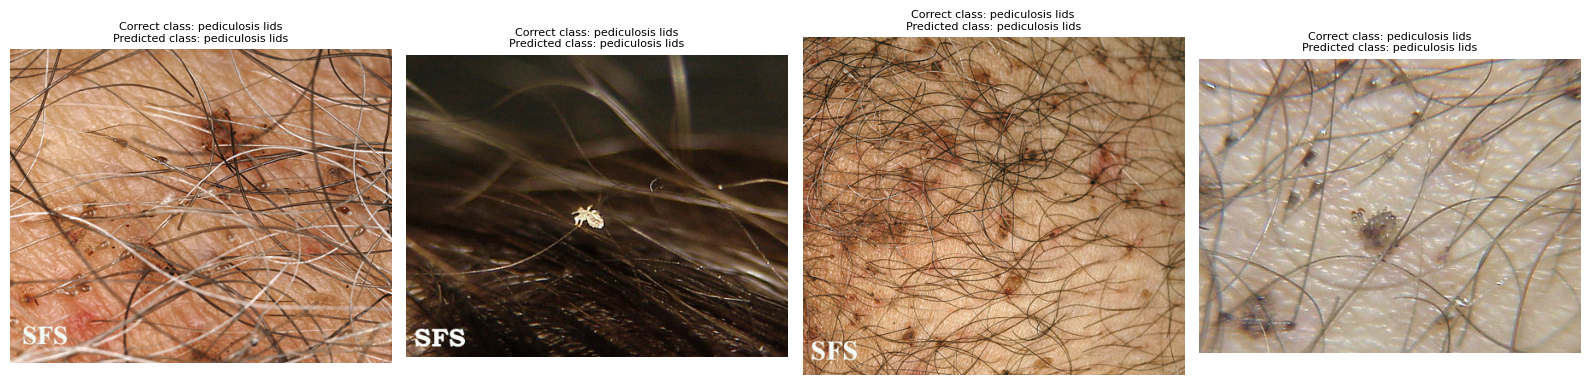

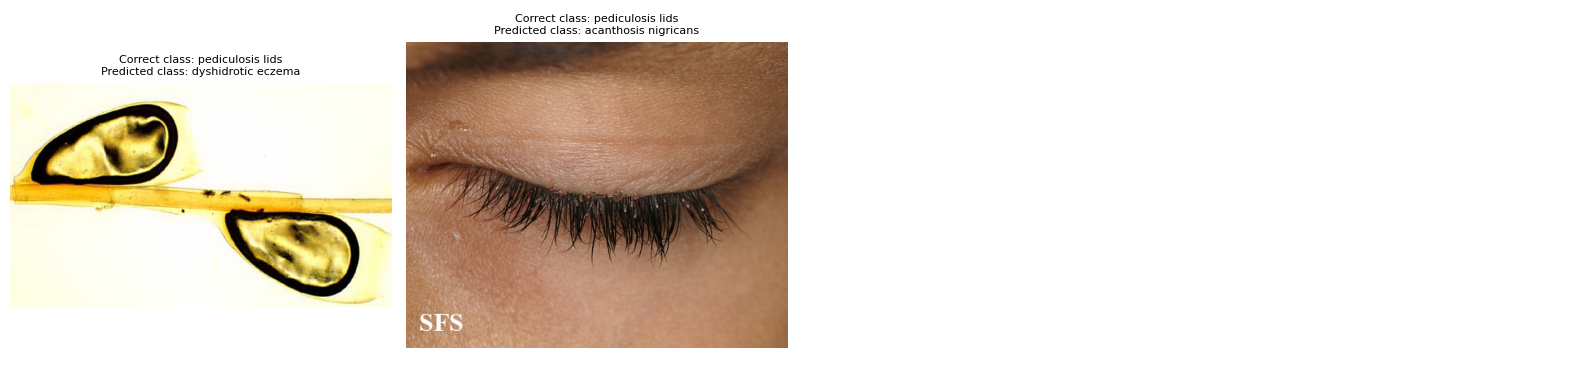

In [154]:
label = 'pediculosis lids'
n = 4 # number of images to sample

image_paths = test_info[(test_info['label'] == label) & (test_info['true_class'] == test_info['pred_class'])]['key'].apply(lambda x: '/content/dataset/test/' + x).sample(n).to_list()
display_images(image_paths)

image_paths = test_info[(test_info['label'] == label) & (test_info['true_class'] != test_info['pred_class'])]['key'].apply(lambda x: '/content/dataset/test/' + x).head(2).to_list()

display_images(image_paths)

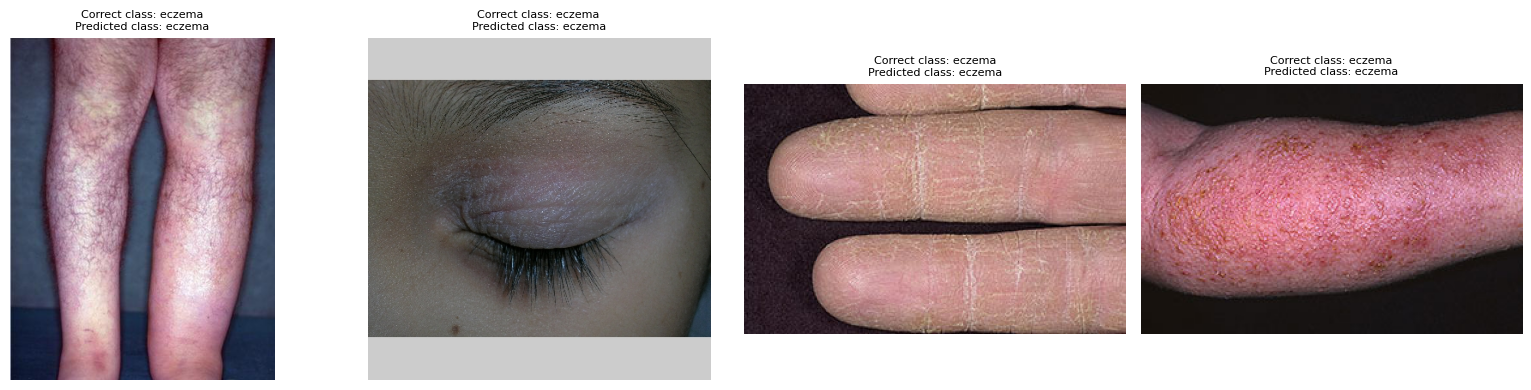

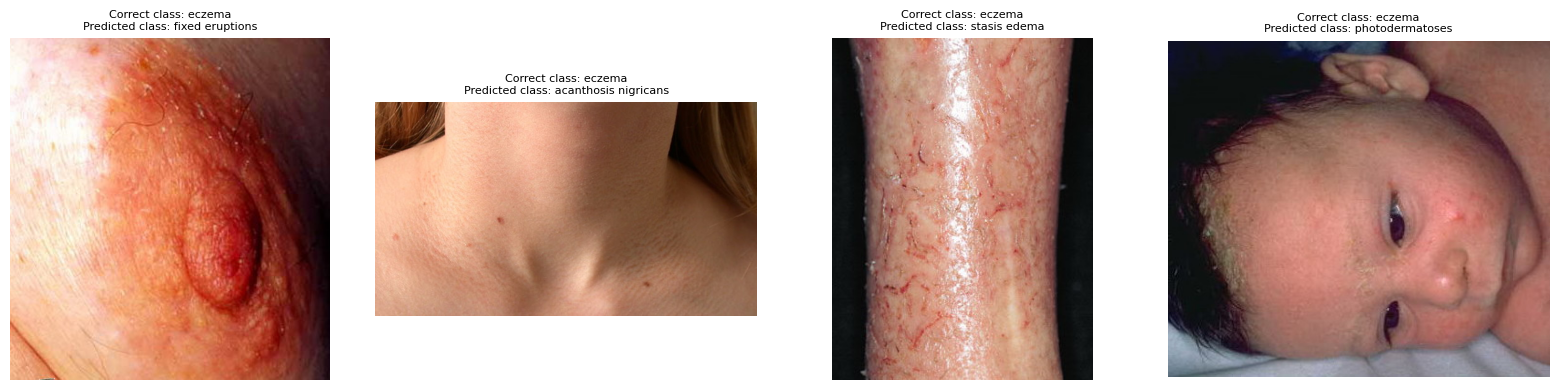

In [164]:
label = 'eczema'
n = 4 # number of images to sample

image_paths = test_info[(test_info['label'] == label) & (test_info['true_class'] == test_info['pred_class'])]['key'].apply(lambda x: '/content/dataset/test/' + x).sample(n).to_list()
display_images(image_paths)

image_paths = test_info[(test_info['label'] == label) & (test_info['true_class'] != test_info['pred_class'])]['key'].apply(lambda x: '/content/dataset/test/' + x).sample(n).to_list()

display_images(image_paths)

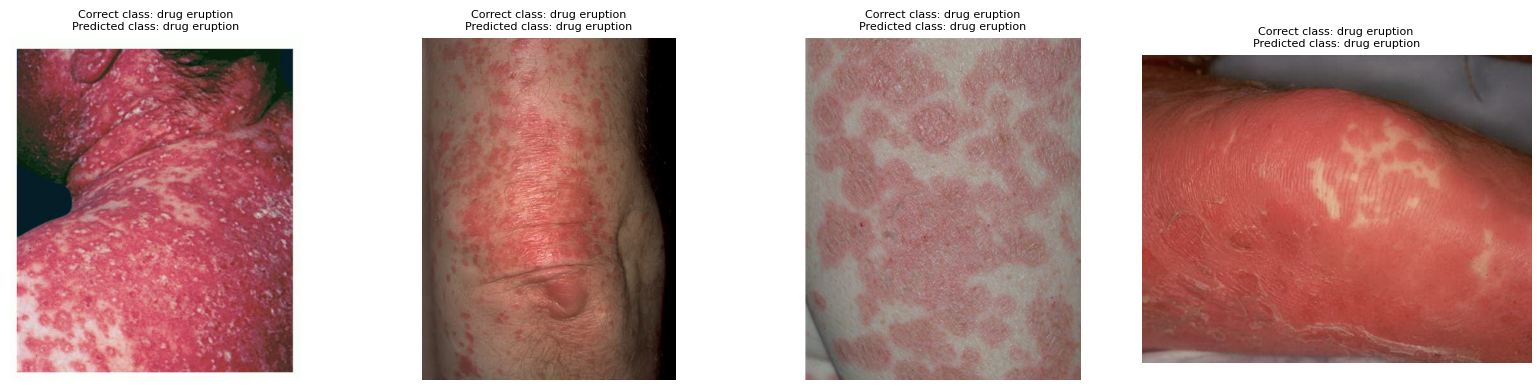

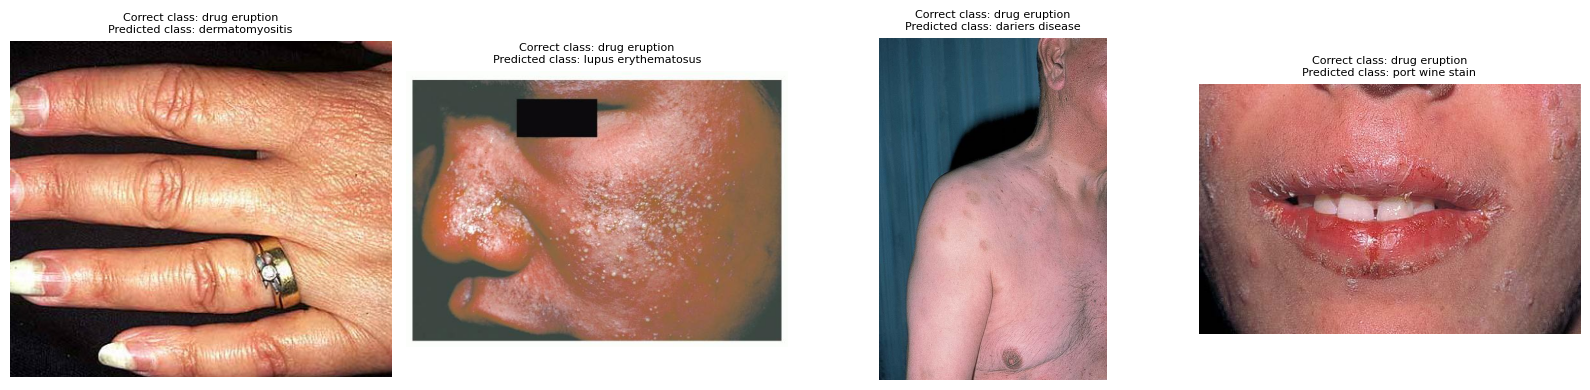

In [162]:
label = 'drug eruption'
n = 4 # number of images to sample

image_paths = test_info[(test_info['label'] == label) & (test_info['true_class'] == test_info['pred_class'])]['key'].apply(lambda x: '/content/dataset/test/' + x).sample(n).to_list()
display_images(image_paths)

image_paths = test_info[(test_info['label'] == label) & (test_info['true_class'] != test_info['pred_class'])]['key'].apply(lambda x: '/content/dataset/test/' + x).sample(n).to_list()

display_images(image_paths)